<a href="https://colab.research.google.com/github/Goldenocean-bety/shiyi/blob/main/examples/image_segmentation/python/image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2023 The MediaPipe Authors. All Rights Reserved.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image Segmenter

## Imports and Setup
Let's start with the base imports for running this MediaPipe sample.

In [2]:
!pip install -q mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 73.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 9.7 MB/s eta 0:00:00


## Download the image segmenter model

The next thing you will need to do is download the image segmentation model that will be used for this demo. In this case you will use the DeepLab v3 model.

In [3]:
#@title Start downloading here.
!wget -O deeplabv3.tflite -q https://storage.googleapis.com/mediapipe-models/image_segmenter/deeplab_v3/float32/1/deeplab_v3.tflite

## Download a test image

After downloading the model, it's time to grab an image that you can use for testing! It's worth noting that while this is working with a single image, you can download a collection of images to store in the `IMAGE_FILENAMES` array.

In [4]:
import urllib

IMAGE_FILENAMES = ['segmentation_input_rotation0.jpg']

for name in IMAGE_FILENAMES:
  url = f'https://storage.googleapis.com/mediapipe-assets/{name}'
  urllib.request.urlretrieve(url, name)

## Preview the downloaded image

With the test image downloaded, go ahead and display it.

segmentation_input_rotation0.jpg


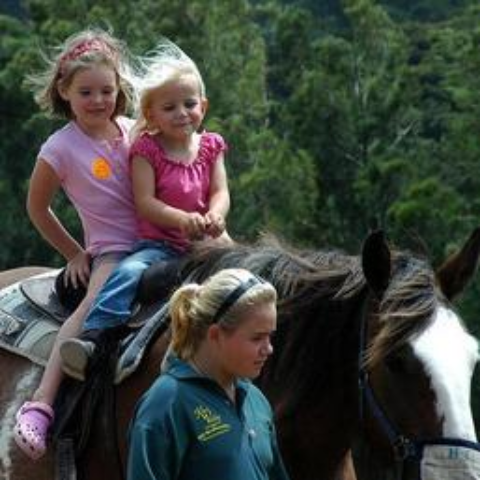

In [5]:
import cv2
from google.colab.patches import cv2_imshow
import math

# Height and width that will be used by the model
DESIRED_HEIGHT = 480
DESIRED_WIDTH = 480

# Performs resizing and showing the image
def resize_and_show(image):
  h, w = image.shape[:2]
  if h < w:
    img = cv2.resize(image, (DESIRED_WIDTH, math.floor(h/(w/DESIRED_WIDTH))))
  else:
    img = cv2.resize(image, (math.floor(w/(h/DESIRED_HEIGHT)), DESIRED_HEIGHT))
  cv2_imshow(img)


# Preview the image(s)
images = {name: cv2.imread(name) for name in IMAGE_FILENAMES}
for name, image in images.items():
  print(name)
  resize_and_show(image)

## Running inference and visualizing the results
To run inference using the image segmentation MediaPipe Task, you will need to initialize the `ImageSegmenter` using the model. This example will separate the background and foreground of the image and apply separate colors for them to highlight where each distinctive area exists. Image segmentation here will use a category mask, which applies a category to each found item based on confidence.

In [6]:
import numpy as np
import mediapipe as mp

from mediapipe.tasks import python
from mediapipe.tasks.python import vision


BG_COLOR = (192, 192, 192) # gray
MASK_COLOR = (255, 255, 255) # white


# Create the options that will be used for ImageSegmenter
base_options = python.BaseOptions(model_asset_path='deeplabv3.tflite')
options = vision.ImageSegmenterOptions(base_options=base_options,
                                       output_category_mask=True)

# Create the image segmenter
with vision.ImageSegmenter.create_from_options(options) as segmenter:

  # Loop through demo image(s)
  for image_file_name in IMAGE_FILENAMES:

    # Create the MediaPipe image file that will be segmented
    image = mp.Image.create_from_file(image_file_name)

    # Get the image data first to retrieve its dimensions
    image_data = image.numpy_view()
    H, W, _ = image_data.shape # Get actual height and width

    # Retrieve the masks for the segmented image
    segmentation_result = segmenter.segment(image)
    category_mask = segmentation_result.category_mask

    # Fix: Squeeze the category mask to remove any potential single-dimensional axes
    # And explicitly reshape to the image's H, W to ensure it's 2D
    category_mask_view = category_mask.numpy_view()
    category_mask_squeezed = np.squeeze(category_mask_view).reshape(H, W) # Reshape to (H, W)

    # Generate solid color images for showing the output segmentation mask.
    # fg_image and bg_image are already correctly shaped (H, W, 3) from image_data.shape
    fg_image = np.zeros(image_data.shape, dtype=np.uint8)
    fg_image[:] = MASK_COLOR
    bg_image = np.zeros(image_data.shape, dtype=np.uint8)
    bg_image[:] = BG_COLOR

    # Use the correctly shaped 2D mask for creating the condition, resulting in (H, W, 3)
    condition = np.stack((category_mask_squeezed,) * 3, axis=-1) > 0.2
    output_image = np.where(condition, fg_image, bg_image)

    print(f'Segmentation mask of {name}:')
    resize_and_show(output_image)


Segmentation mask of segmentation_input_rotation0.jpg:


error: OpenCV(4.12.0) /io/opencv/modules/imgproc/src/resize.cpp:3845: error: (-215:Assertion failed) !dsize.empty() in function 'resize'


Now that you know how to separate the foreground and background of an image, let's take it a step further and blur the background for an effect similar to what is provided by Google Hangouts.

In [ ]:
# Blur the image background based on the segmentation mask.

# Create the segmenter
with python.vision.ImageSegmenter.create_from_options(options) as segmenter:

  # Loop through available image(s)
  for image_file_name in IMAGE_FILENAMES:

    # Create the MediaPipe Image
    image = mp.Image.create_from_file(image_file_name)

    # Retrieve the category masks for the image
    segmentation_result = segmenter.segment(image)
    category_mask = segmentation_result.category_mask

    # Convert the BGR image to RGB
    image_data = cv2.cvtColor(image.numpy_view(), cv2.COLOR_BGR2RGB)

    # Apply effects
    blurred_image = cv2.GaussianBlur(image_data, (55,55), 0)
    condition = np.stack((category_mask.numpy_view(),) * 3, axis=-1) > 0.1
    output_image = np.where(condition, image_data, blurred_image)

    print(f'Blurred background of {image_file_name}:')
    resize_and_show(output_image)